In [68]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import statsmodels.formula.api as smf
from sklearn import preprocessing

In [69]:
# Load waffle data_labels
df_waffle_divorce = pd.read_csv('/home/amit/AmitKushwaha/Courses/Books/StatisticalRethinkingBook/Data/WaffleDivorce.csv',sep=';')

# Add LDS Population percent
df_waffle_divorce['LDSPopulation'] =np.array ([0.0077, 0.0453, 0.0610, 0.0104, 0.0194, 0.0270, 0.0044, 0.0057, 0.0041, 0.0075, 0.0082, 0.0520, 0.2623, 0.0045, 0.0067, 0.0090, 0.0130, 0.0079, 0.0064, 0.0082, 0.0072, 0.0040, 0.0045, 0.0059, 0.0073, 0.0116, 0.0480, 0.0130, 0.0065, 0.0037, 0.0333, 0.0041, 0.0084, 0.0149, 0.0053, 0.0122, 0.0372, 0.0040, 0.0039, 0.0081, 0.0122, 0.0076, 0.0125, 0.6739, 0.0074, 0.0113, 0.0390, 0.0093, 0.0046, 0.1161])

scaler = preprocessing.StandardScaler()
# Marriage = scaler.fit_transform(df_waffle_divorce['Marriage'].values.reshape(-1,1))
# MedianAgeMarriage = scaler.fit_transform(df_waffle_divorce['MedianAgeMarriage'].values.reshape(-1,1))
Marriage = (df_waffle_divorce['Marriage'].values.reshape(-1,1))
MedianAgeMarriage =(df_waffle_divorce['MedianAgeMarriage'].values.reshape(-1,1))
LogLDSPopulation = scaler.fit_transform(np.log(df_waffle_divorce['LDSPopulation'].values).reshape(-1,1))
Divorce = df_waffle_divorce['Divorce'].values.reshape(-1,1)

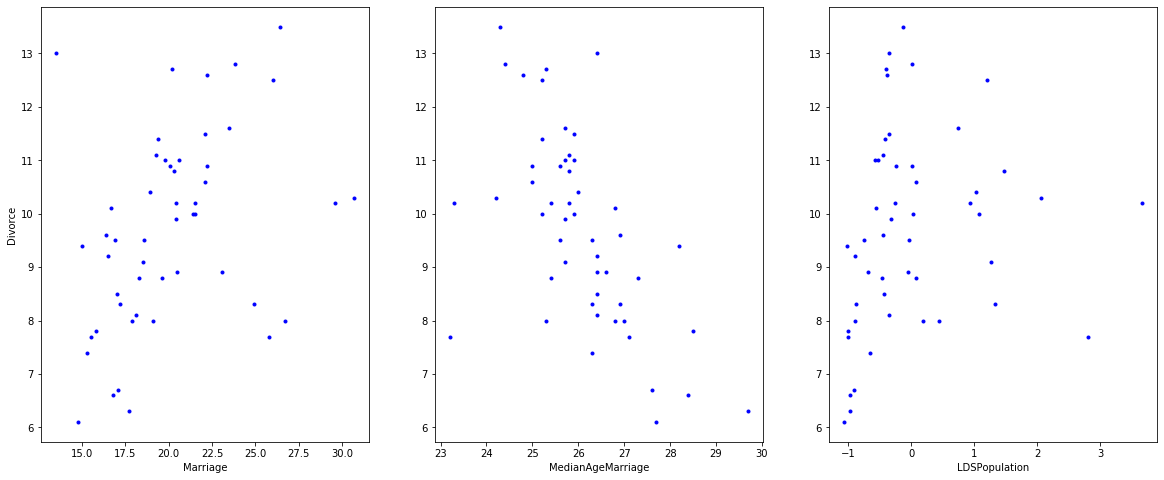

In [70]:
fig,ax = plt.subplots(ncols=3,figsize=(20,8))
ax[0].plot(Marriage,Divorce,'b.')
ax[1].plot(MedianAgeMarriage,Divorce,'b.')
ax[2].plot(LogLDSPopulation,Divorce,'b.')
ax[0].set_xlabel('Marriage')
ax[1].set_xlabel('MedianAgeMarriage')
ax[2].set_xlabel('LDSPopulation')
ax[0].set_ylabel('Divorce')
plt.show()

###  Build a model

In [71]:
# Model with both predictors
with pm.Model() as model_collinear:
    a = pm.Normal('a', mu=10, sigma=10)
    bm = pm.Normal('bm', mu=0, sigma=1)
    ba = pm.Normal('ba', mu=0, sigma=1)
    blds = pm.Normal('blds', mu=0, sigma=1)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    mu = pm.Deterministic('mu', a + ba*MedianAgeMarriage + bm*Marriage + blds*LogLDSPopulation)
    h = pm.Normal('h', mu=mu, sigma=sigma, observed=Divorce)
    trace_collinear = pm.sample(cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, blds, ba, bm, a]
Sampling 2 chains, 1 divergences: 100%|██████████| 2000/2000 [00:17<00:00, 113.85draws/s]
The acceptance probability does not match the target. It is 0.8988945207634321, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


(<Figure size 432x475.2 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f01e319dfd0>],
       dtype=object))

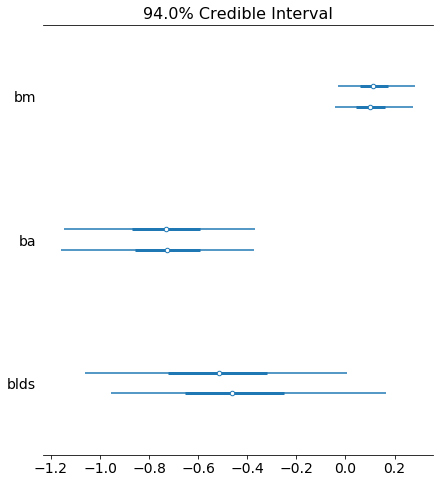

In [72]:
# Plots
az.plot_forest(trace_collinear, var_names=['bm','ba','blds'])

In [73]:
def plot_hpd(trace_data, ax, varname, xlabel, ylabel, var_dict):
    seq = np.linspace(var_dict[varname].min(), var_dict[varname].max(), 50)
    mu_pred = trace_collinear[varname] * seq[:,None] 
    for key,val in var_dict.items():
        if key==varname:
            continue
        else:
            mu_pred += trace_collinear[key] * val.mean()
    mu_pred += trace_collinear['a']

    ax.plot(seq, mu_pred.mean(1), 'k')
    ax.plot(var_dict[varname],Divorce,'b.')
    az.plot_hpd(seq, mu_pred.T,
                fill_kwargs={'alpha': 0},
                plot_kwargs={'alpha':1, 'color':'k', 'ls':'--'},ax=ax)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

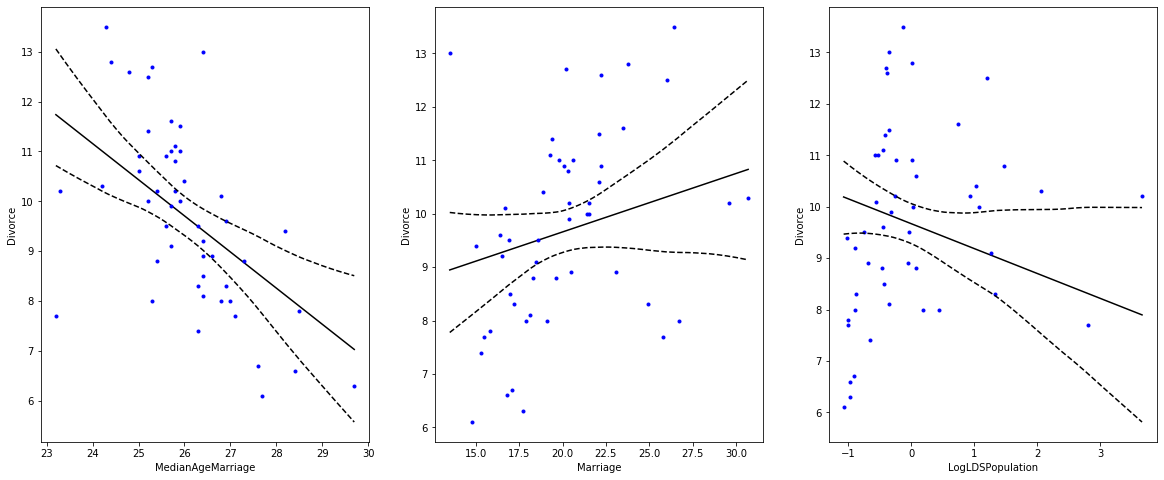

In [74]:
fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(20, 8))
var_dict = {'ba':MedianAgeMarriage, 'bm':Marriage, 'blds':LogLDSPopulation}
plot_hpd(trace_collinear, ax[0], 'ba', 'MedianAgeMarriage', 'Divorce', var_dict)
plot_hpd(trace_collinear, ax[1], 'bm', 'Marriage', 'Divorce', var_dict)
plot_hpd(trace_collinear, ax[2], 'blds', 'LogLDSPopulation', 'Divorce', var_dict)

In [75]:
az.summary(trace_collinear, ['a', 'ba', 'bm', 'blds', 'sigma'], credible_interval=.89).round(3)

,mean,sd,hpd_5.5%,hpd_94.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,26.330,6.221,15.982,36.007,0.334,0.236,347.0,347.0,354.0,403.0,1.00
ba,-0.724,0.207,-1.086,-0.422,0.011,0.008,348.0,348.0,352.0,410.0,1.00
bm,0.109,0.085,-0.013,0.250,0.004,0.003,414.0,402.0,421.0,488.0,1.01
blds,-0.484,0.299,-0.939,-0.001,0.015,0.011,388.0,388.0,387.0,379.0,1.02
sigma,1.513,0.179,1.200,1.770,0.010,0.007,302.0,302.0,286.0,326.0,1.00
